In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.layers import Input
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

2024-04-10 13:01:25.873875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 13:01:25.874006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 13:01:26.041122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
disease_types = ['Potato___Early_blight','Potato___Late_blight','Potato___healthy']
data_dir = '/kaggle/input/plant-village-terox/PlantVillage/potato'
train_dir = os.path.join(data_dir)


In [4]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
2147,Potato___healthy/a8d687be-3777-403f-bae7-5c8c1...,2,Potato___healthy
2148,Potato___healthy/a02b6205-b40a-4178-8b34-3494f...,2,Potato___healthy
2149,Potato___healthy/20ac28d6-5708-4e31-8676-1b197...,2,Potato___healthy
2150,Potato___healthy/d1752ed4-a0a7-4075-917d-205c0...,2,Potato___healthy
2151,Potato___healthy/7bfda067-6e35-4af5-a9c4-4b3b5...,2,Potato___healthy


In [5]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Potato___Late_blight/6af65e0d-c1a5-4a28-9ecb-1...,1,Potato___Late_blight
1,Potato___Late_blight/b74d0fd1-9af7-4053-8538-e...,1,Potato___Late_blight
2,Potato___Early_blight/92a30efc-6b2f-4e17-8688-...,0,Potato___Early_blight
3,Potato___Early_blight/52fb5725-33cf-4076-9abc-...,0,Potato___Early_blight
4,Potato___Late_blight/ac35ccac-2c52-4af5-b0e3-3...,1,Potato___Late_blight


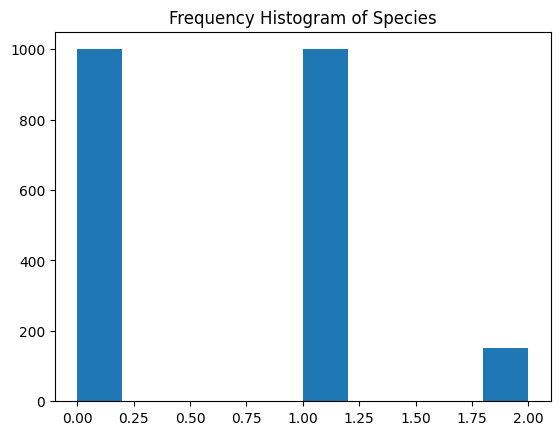

<Figure size 1200x1200 with 0 Axes>

In [6]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

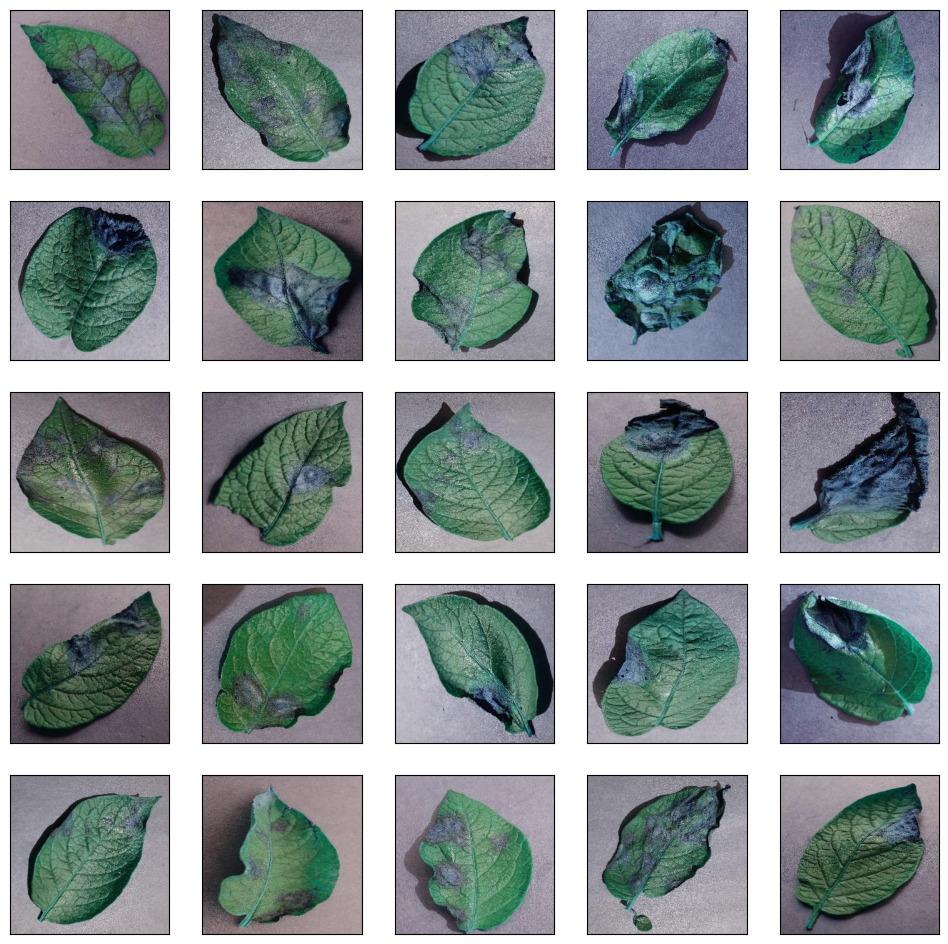

In [7]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
plot_defects('Potato___Late_blight', 5, 5)

In [8]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2152it [00:17, 122.11it/s]

Train Shape: (2152, 64, 64, 3)


In [10]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=3)
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [11]:
EPOCHS = 100
SIZE=64
N_ch=3
def build_densenet(): #model name
    densenet = DenseNet121(weights='imagenet', include_top=False)
    #https://www.google.com/search?q=dense121+model+architecture&client=firefox-b-d&sca_esv=580163193&tbm=isch&sxsrf=AM9HkKk8njH2g2Y_TO_jeqyysBpEu3zasw:1699374737373&source=lnms&sa=X&ved=2ahUKEwjhrr6cqLKCAxWzUGwGHYu2AZQQ_AUoAXoECAIQAw#imgrc=8djlGx7kC2QAQM

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(3,activation = 'softmax', name='root')(x) #imp : look for softmax activation function
 

    # model
    model = Model(input,output)
    from keras.optimizers import Adam,Adadelta

# Create an instance of the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=0.00085,beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [25]:
mdel = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model1.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = mdel.fit(datagen.flow(X_train, Y_train, batch_size=32),
               steps_per_epoch=X_train.shape[0] // 32,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer,checkpoint],
               validation_data=(X_val, Y_val))

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ root (Dense)                    │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,173,783 (27.37 MB)

 Trainable params: 7,087,831 (27.04 MB)

 Non-trainable params: 85,952 (335.75 KB)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1712755712.127840      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712755772.691624      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712755782.546839      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.35126, saving model to model.keras


W0000 00:00:1712755787.441207      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


53/53 - 197s - 4s/step - accuracy: 0.4292 - loss: 1.6448 - val_accuracy: 0.2599 - val_loss: 1.3513 - learning_rate: 8.5000e-04
Epoch 2/100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.35126
53/53 - 0s - 8ms/step - accuracy: 0.4062 - loss: 1.4073 - val_accuracy: 0.2622 - val_loss: 1.3564 - learning_rate: 8.5000e-04
Epoch 3/100

Epoch 3: val_loss improved from 1.35126 to 0.88346, saving model to model.keras
53/53 - 5s - 87ms/step - accuracy: 0.6288 - loss: 0.9683 - val_accuracy: 0.6241 - val_loss: 0.8835 - learning_rate: 8.5000e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.88346 to 0.88310, saving model to model.keras
53/53 - 2s - 35ms/step - accuracy: 0.6562 - loss: 1.0202 - val_accuracy: 0.6265 - val_loss: 0.8831 - learning_rate: 8.5000e-04
Epoch 5/100

Epoch 5: val_loss improved from 0.88310 to 0.79397, saving model to model.keras
53/53 - 5s - 89ms/step - accuracy: 0.7407 - loss: 0.6645 - val_accuracy: 0.6636 - val_loss: 0.7940 - learning_rate: 8.5000e-04
Epoch 6/100

Epoch 6: val_loss did not improve from 0.79397
53/53 - 0s - 5ms/step - accuracy: 0.8125 - loss: 0.6671 - val_accuracy: 0.6613 - val_loss: 0.8043 - learni

In [26]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = mdel.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9818 - loss: 0.0444
Final Loss: 0.0435454286634922, Final Accuracy: 0.9814385175704956


In [29]:
from sklearn.metrics import classification_report
report = classification_report(Y_true, Y_pred, target_names=disease_types)
print(report)

                       precision    recall  f1-score   support

Potato___Early_blight       0.98      1.00      0.99       201
 Potato___Late_blight       1.00      0.96      0.98       203
     Potato___healthy       0.87      1.00      0.93        27

             accuracy                           0.98       431
            macro avg       0.95      0.99      0.97       431
         weighted avg       0.98      0.98      0.98       431



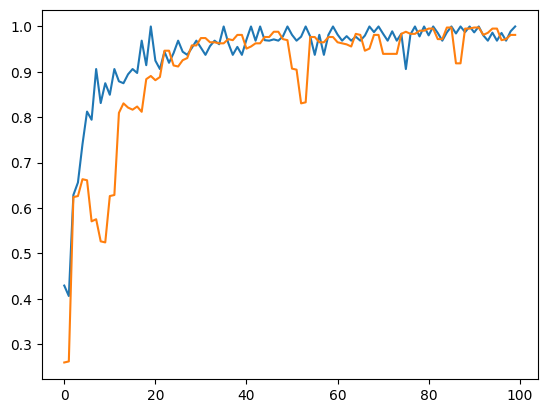

In [27]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Text(0.5, 192.58159722222217, 'Predicted')

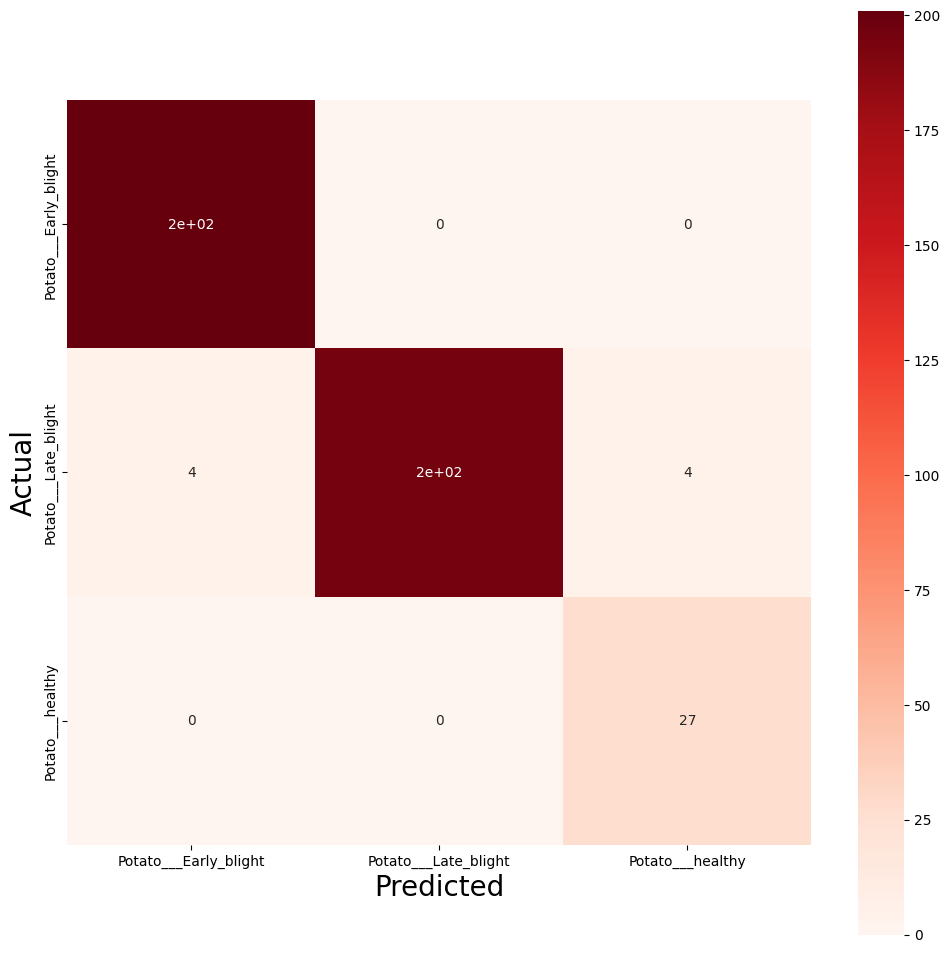

In [30]:
Y_pred = mdel.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Reds, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)